In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score,
    confusion_matrix, classification_report
)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import statsmodels.api as sm
import shap


c:\Users\giulio.damico\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Carico il dataset
df = pd.read_csv("dataset.csv")


In [28]:
# Controllo struttura
print(df.head())
print(df.info())
print(df.describe(include="all"))


   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [29]:
# Controllo eventuali NA
print(df.isna().sum())

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


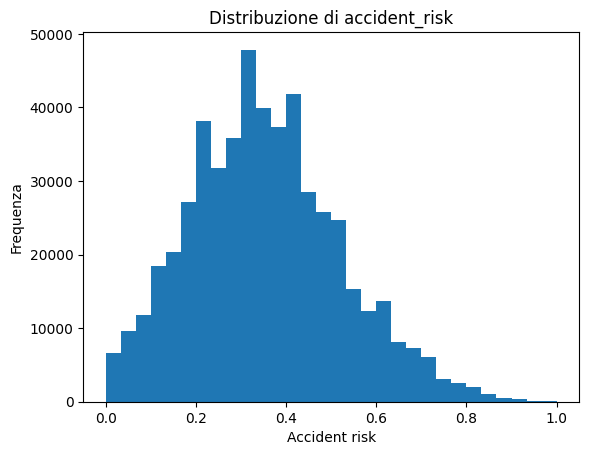

In [30]:
# Distribuzione della variabile target
plt.hist(df["accident_risk"], bins=30)
plt.xlabel("Accident risk")
plt.ylabel("Frequenza")
plt.title("Distribuzione di accident_risk")
plt.show()

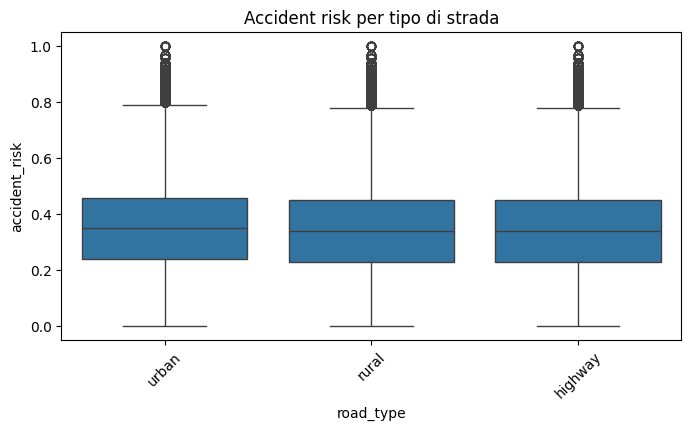

In [31]:
# Boxplot di accident_risk per tipo di strada
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="road_type", y="accident_risk")
plt.xticks(rotation=45)
plt.title("Accident risk per tipo di strada")
plt.show()

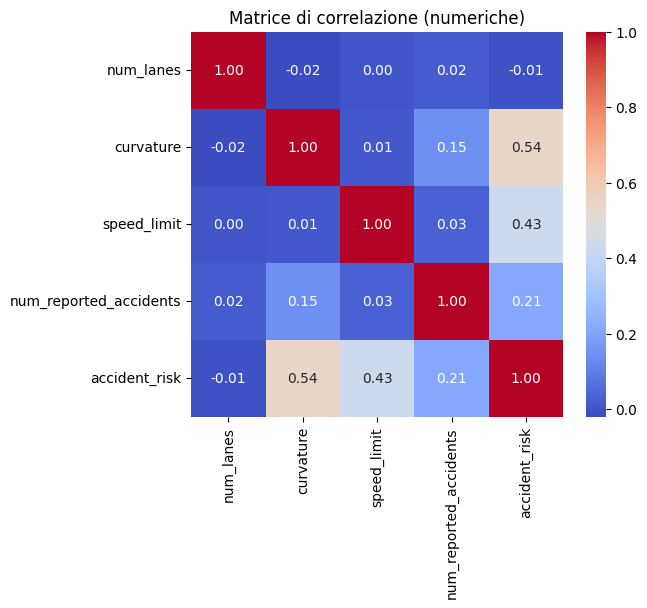

In [32]:
# Correlazione tra variabili numeriche
num_cols = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents", "accident_risk"]
corr = df[num_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di correlazione (numeriche)")
plt.show()

In [33]:
# Variabile target
y = df["accident_risk"]

# Features: tutte tranne id e accident_risk
X = df.drop(columns=["id", "accident_risk"])

In [34]:
categorical_features = ["road_type", "lighting", "weather", "time_of_day"]
# bool le tratto come numeriche (0/1)
numeric_features = ["num_lanes", "curvature", "speed_limit",
                    "road_signs_present", "public_road",
                    "holiday", "school_season",
                    "num_reported_accidents"]


In [35]:
# Trasformatore per le categoriche
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

# Trasformatore per le numeriche
numeric_transformer = StandardScaler()

# ColumnTransformer combinato
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [37]:
pipe_ols = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

pipe_ols.fit(X_train, y_train)

y_pred_ols = pipe_ols.predict(X_test)

mse_ols = mean_squared_error(y_test, y_pred_ols)
mae_ols = mean_absolute_error(y_test, y_pred_ols)
r2_ols  = r2_score(y_test, y_pred_ols)

print("OLS - MSE:", mse_ols)
print("OLS - MAE:", mae_ols)
print("OLS - R2 :", r2_ols)


OLS - MSE: 0.005406787753204658
OLS - MAE: 0.05831216757325717
OLS - R2 : 0.8041884067087809


In [38]:
pipe_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge())
])

param_grid_ridge = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid_ridge,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

print("Best alpha Ridge:", grid_ridge.best_params_)

y_pred_ridge = grid_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge  = r2_score(y_test, y_pred_ridge)

print("Ridge - MSE:", mse_ridge)
print("Ridge - MAE:", mae_ridge)
print("Ridge - R2 :", r2_ridge)


Best alpha Ridge: {'model__alpha': 1}
Ridge - MSE: 0.0054067882825568295
Ridge - MAE: 0.05831217563741254
Ridge - R2 : 0.8041883875378245


In [39]:
pipe_lasso = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Lasso(max_iter=10000))
])

param_grid_lasso = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_lasso = GridSearchCV(
    pipe_lasso,
    param_grid=param_grid_lasso,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid_lasso.fit(X_train, y_train)

print("Best alpha Lasso:", grid_lasso.best_params_)

y_pred_lasso = grid_lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso  = r2_score(y_test, y_pred_lasso)

print("Lasso - MSE:", mse_lasso)
print("Lasso - MAE:", mae_lasso)
print("Lasso - R2 :", r2_lasso)


Best alpha Lasso: {'model__alpha': 0.0001}
Lasso - MSE: 0.005406974117382402
Lasso - MAE: 0.05831328231074316
Lasso - R2 : 0.8041816573655031


In [40]:
# Fit del preprocessor SOLO sui train
preprocessor.fit(X_train)

# Trasformo tutto il dataset (per avere più potenza statistica)
X_transformed = preprocessor.transform(X)

In [ ]:
# Converto in array numpy denso
# X_transformed = X_transformed.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [42]:
X_sm = sm.add_constant(X_transformed)

In [43]:
ols_sm = sm.OLS(y, X_sm)
ols_results = ols_sm.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:          accident_risk   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 1.336e+05
Date:                Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:50:23   Log-Likelihood:             6.1696e+05
No. Observations:              517754   AIC:                        -1.234e+06
Df Residuals:                  517737   BIC:                        -1.234e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2360      0.000    775.314      0.0

In [44]:
# Prendo i nomi delle feature dopo il preprocessing
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(cat_feature_names)

# Costruisco DataFrame con coefficienti (escludendo la costante che è il primo elemento)
coef_df = pd.DataFrame({
    "feature": ["const"] + all_feature_names,
    "coef": ols_results.params
})

print(coef_df.head(20))

                      feature      coef
const                   const  0.235954
x1                  num_lanes  0.000702
x2                  curvature  0.088458
x3                speed_limit  0.080529
x4         road_signs_present -0.000583
x5                public_road -0.000372
x6                    holiday -0.000141
x7              school_season  0.000174
x8     num_reported_accidents  0.014108
x9            road_type_rural -0.000625
x10           road_type_urban -0.000036
x11              lighting_dim -0.000030
x12            lighting_night  0.187295
x13             weather_foggy  0.091714
x14             weather_rainy  0.092984
x15       time_of_day_evening  0.000916
x16       time_of_day_morning -0.001050


In [45]:
threshold = df["accident_risk"].median()
print("Threshold (mediana):", threshold)

y_class = (df["accident_risk"] >= threshold).astype(int)


Threshold (mediana): 0.34


In [46]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)


In [47]:
rf_clf = RandomForestClassifier(random_state=42)

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_clf)
])


In [48]:
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}


In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="roc_auc",   # buona metrica anche in caso di sbilanciamento
    n_jobs=-1
)

grid_rf.fit(X_train_clf, y_train_clf)

print("Migliori parametri RF:", grid_rf.best_params_)
print("Best CV ROC-AUC:", grid_rf.best_score_)

Migliori parametri RF: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9589682597642483


In [50]:
best_rf = grid_rf.best_estimator_

y_pred_clf = best_rf.predict(X_test_clf)
y_proba_clf = best_rf.predict_proba(X_test_clf)[:, 1]

acc  = accuracy_score(y_test_clf, y_pred_clf)
f1   = f1_score(y_test_clf, y_pred_clf)
roc  = roc_auc_score(y_test_clf, y_proba_clf)
bacc = balanced_accuracy_score(y_test_clf, y_pred_clf)

print("Accuracy:", acc)
print("F1-score:", f1)
print("ROC-AUC:", roc)
print("Balanced Accuracy:", bacc)

print("Confusion matrix:\n", confusion_matrix(y_test_clf, y_pred_clf))
print("\nClassification report:\n", classification_report(y_test_clf, y_pred_clf))

Accuracy: 0.8832942221707178
F1-score: 0.886801112786744
ROC-AUC: 0.9587793244106245
Balanced Accuracy: 0.8836385624368384
Confusion matrix:
 [[44129  5372]
 [ 6713 47337]]

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     49501
           1       0.90      0.88      0.89     54050

    accuracy                           0.88    103551
   macro avg       0.88      0.88      0.88    103551
weighted avg       0.88      0.88      0.88    103551



In [4]:
# Per fare la permutation importance, serve il modello già fit (best_rf)
result_perm = permutation_importance(
    best_rf,
    X_test_clf,
    y_test_clf,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Prendo nomi delle feature preprocessate
preprocessor.fit(X_train_clf)
X_test_transformed = preprocessor.transform(X_test_clf)

ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

perm_importances = pd.Series(
    result_perm.importances_mean,
    index=all_feature_names
).sort_values(ascending=False)

print(perm_importances.head(20))

plt.figure(figsize=(8, 6))
perm_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Permutation importance (top 20)")
plt.show()

NameError: name 'permutation_importance' is not defined

In [1]:
# Per TreeExplainer conviene lavorare sul RandomForest interno,
# con i dati già trasformati
X_train_transformed = preprocessor.transform(X_train_clf)
X_test_transformed  = preprocessor.transform(X_test_clf)

rf_internal = best_rf.named_steps["model"]

explainer = shap.TreeExplainer(rf_internal)
shap_values = explainer.shap_values(X_test_transformed)

NameError: name 'preprocessor' is not defined

In [ ]:
# Attenzione: SHAP usa array numpy, i nomi li mettiamo a mano
shap.summary_plot(shap_values[1], X_test_transformed, feature_names=all_feature_names)

In [ ]:
i = 0  # prima osservazione del test
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][i, :],
    X_test_transformed[i, :],
    feature_names=all_feature_names
)

In [ ]:
features_for_pdp = [numeric_features.index("num_reported_accidents")]
# oppure una combinazione 2D: [(indice1, indice2)]

PartialDependenceDisplay.from_estimator(
    best_rf,
    X_test_clf,
    features=[features_for_pdp],
    feature_names=numeric_features + list(cat_feature_names),
    kind="average"
)
plt.show()